# Explicação do projeto 

In [24]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image

In [25]:
class ImageRecommender:
    def __init__(self, image_folder):
        self.base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
        self.image_directory = image_folder
        self.features = {}
        self.image_paths = []

    def load_and_preprocess_image(self, image_path):
        # Carregar e pré-processar a imagem
        img = image.load_img(image_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return x

    def extract_features(self):
        # Extrair características de todas as imagens no diretório
        for img_file in os.listdir(self.image_directory):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(self.image_directory, img_file)
                
                # Preprocessar imagem
                img_tensor = self.load_and_preprocess_image(img_path)
                
                # Extrair características usando VGG16
                features = self.base_model.predict(img_tensor, verbose=0)
                
                # Armazenar características e caminho da imagem
                self.features[img_path] = features.flatten()
                self.image_paths.append(img_path)
        
        print(f"Características extraídas de {len(self.features)} imagens")

    def get_recommendations(self, query_image_path, num_recommendations=5):
        # Extrair características da imagem de consulta
        query_tensor = self.load_and_preprocess_image(query_image_path)
        query_features = self.base_model.predict(query_tensor).flatten()
        
        # Calcular similaridade da imagem da query com todas as outras imagens
        similarities = {}
        for img_path, feat in self.features.items():
            similarity = cosine_similarity(
                query_features.reshape(1, -1),
                feat.reshape(1, -1)
            )[0][0] # retorna uma matriz de similaridades. Por isso [0] [0]
            similarities[img_path] = similarity
        
        # Ordenar por similaridade e retornar os top N
        sorted_items = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
        return sorted_items[1:num_recommendations+1] # evitar de pegar a propria imagem de query

    def visualize_recommendations(self, query_image_path, recommendations):
        # Plotar imagem de consulta e recomendações
        plt.figure(figsize=(15, 5))
        
        # Imagem de consulta
        plt.subplot(1, len(recommendations) + 1, 1)
        query_img = Image.open(query_image_path)
        plt.imshow(query_img)
        plt.title('Imagem alvo')
        plt.axis('off')
        
        # Imagens recomendadas
        for idx, (img_path, similarity) in enumerate(recommendations):
            plt.subplot(1, len(recommendations) + 1, idx + 2)
            rec_img = Image.open(img_path)
            plt.imshow(rec_img)
            plt.title(f'Similaridade: {similarity:.2f}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show();

In [26]:
watches_folder = "./watches/"

In [27]:
recommender = ImageRecommender(watches_folder)

recommender.extract_features()

Características extraídas de 501 imagens


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


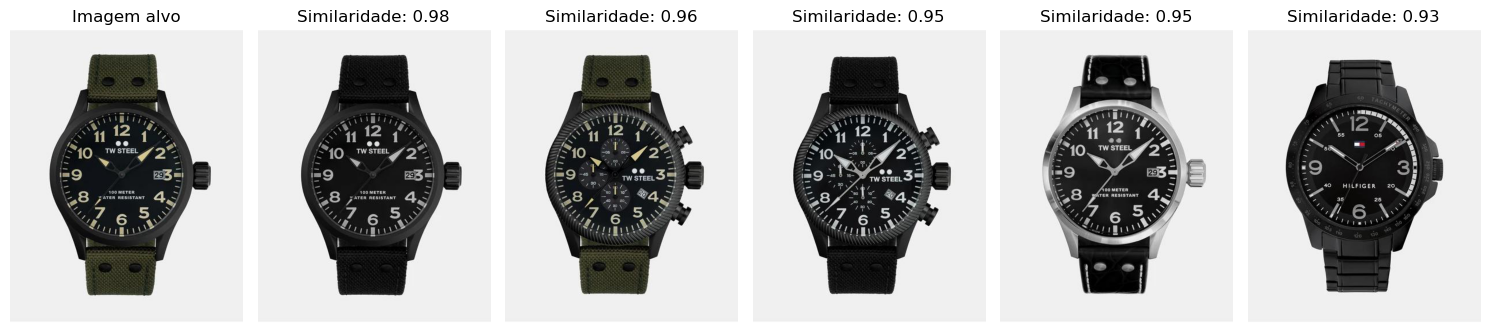

In [30]:
query_image = os.path.join(watches_folder, "2.jpg")

recommendations = recommender.get_recommendations(query_image)

recommender.visualize_recommendations(query_image, recommendations)